In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import collections
from etils import epath
from ml_collections import config_dict
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import polars as pl
import tensorflow as tf

from chirp import audio_utils
from chirp.inference import a2o_utils
from chirp.inference import interface
from chirp.inference import tf_examples
from chirp.inference import models
from chirp.models import metrics
from chirp.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib
import requests
import json
import pickle
import sys
from scipy.io import wavfile
import os

2024-06-27 09:38:37.078475: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-27 09:38:37.113184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 09:38:37.113234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 09:38:37.113242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 09:38:37.119893: I tensorflow/core/platform/cpu_feature_g

In [2]:
sample_rate = 32000

In [3]:
output_filepath = epath.Path('outputs_all') / 'inference_custom.parquet'
outputs = pl.read_parquet(str(output_filepath))

In [27]:
outputs.shape

(1263169890, 4)

In [4]:
aru2point = pl.read_csv('./aru2point/aru2point_all.csv')

In [5]:
outputs_agg = outputs.group_by(['filename', 'label']).agg(pl.col('logit').max())

In [6]:
outputs_agg = outputs_agg.with_columns((pl.col('filename').str.split('/').map_elements(lambda x: x[-1])).alias('filename'))

/tmp/ipykernel_4149662/3711136033.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  outputs_agg = outputs_agg.with_columns((pl.col('filename').str.split('/').map_elements(lambda x: x[-1])).alias('filename'))


In [7]:
outputs_agg_points = outputs_agg.join(aru2point, on='filename', how='left')

/tmp/ipykernel_4149662/1513925116.py:1: DeprecationWarning: The default coalesce behavior of left join will change to `False` in the next breaking release. Pass `coalesce=True` to keep the current behavior and silence this warning.
  outputs_agg_points = outputs_agg.join(aru2point, on='filename', how='left')


In [8]:
outputs_agg_points

filename,label,logit,point
str,str,f64,f64
"""A1-CLEAR-CAP_20220609_023000.w…","""flaowl_song""",-7.5,null
"""15-PEACOCK_20210606_063000.wav""","""whbnut_call""",-4.02,535.0
"""22-CHEETAH_20230611_090000.wav""","""sonspa_call""",-4.34,534.0
"""28-LANDO_20220617_233000.wav""","""warvir_song""",-6.36,null
"""ORANGE-7-CAP_20190609_190000.w…","""compoo_song""",-3.93,622.0
…,…,…,…
"""20-PARROT_20220607_093000.wav""","""amekes_call""",-4.75,null
"""CLEAR-1-CAPL_20190603_163000.w…","""towsol_song""",-5.38,935.0
"""17-ENSATINA_20230611_210000.wa…","""hamfly_song""",-8.3,714.0


In [10]:
outputs_agg_points.write_parquet('./outputs_all/outputs_agg_points.parquet')

In [8]:
outputs.columns

Index(['filename', 'timestamp_s', 'label', 'logit'], dtype='object')

In [4]:
flaowl = outputs[outputs['label'] == 'flaowl_song']

In [5]:
herwar = outputs.filter(pl.col('label') == 'herwar_song')

In [14]:
btywar = outputs[outputs['label'] == 'btywar_song']

In [45]:
westan = outputs[outputs['label'] == 'westan_song']

In [8]:
lazbun = outputs[outputs['label'] == 'lazbun_song']

In [39]:
bkbwoo = outputs[outputs['label'] == 'bkbwoo_call']

In [58]:
gnttow = outputs[outputs['label'] == 'gnttow_song']

In [15]:
foxspa = outputs[outputs['label'] == 'foxspa_song']

In [63]:
pacwre = outputs[outputs['label'] == 'pacwre1_song']

In [46]:
dusfly = outputs[outputs['label'] == 'dusfly_song']

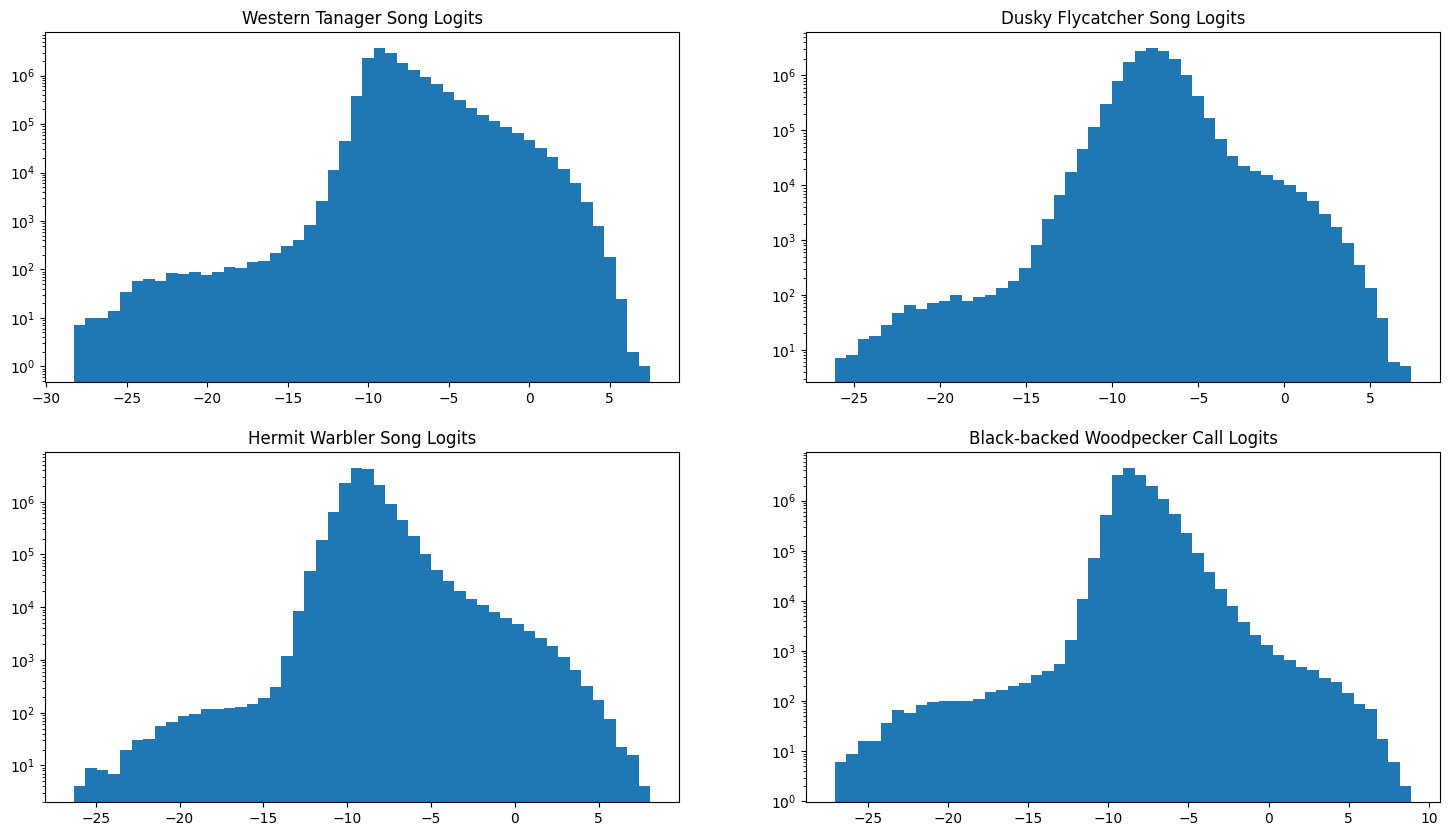

In [48]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.hist(westan['logit'], bins=50)
plt.yscale('log')
plt.title('Western Tanager Song Logits')

plt.subplot(2, 2, 2)
plt.hist(dusfly['logit'], bins=50)
plt.yscale('log')
plt.title('Dusky Flycatcher Song Logits')

plt.subplot(2, 2, 3)
plt.hist(herwar['logit'], bins=50)
plt.yscale('log')
plt.title('Hermit Warbler Song Logits')

plt.subplot(2, 2, 4)
plt.hist(bkbwoo['logit'], bins=50)
plt.yscale('log')
plt.title('Black-backed Woodpecker Call Logits')

plt.show()

In [25]:
def show_classified_spec(filename, offset_s, sample_rate):
    audio = audio_utils.load_audio(filename, sample_rate)
    start = int(offset_s * sample_rate)
    end = start + int(5 * sample_rate)
    audio_snippet = audio[start:end]
    display.plot_audio_melspec(audio_snippet, sample_rate)

def show_spec_classified_species(species, classified, n, audio_path, sample_rate):
    filtered = classified.filter(pl.col('label') == species)
    filtered = filtered.sort(by=['logit'], descending=True)
    filtered = filtered.filter(pl.col('logit') < -2)
    filtered = filtered.to_pandas(use_pyarrow_extension_array=True)
    # year = filtered['filename'].str.split('/').str[0].astype(int)
    # filtered = filtered[year <= 2019]
    for i, window in enumerate(filtered.iterrows()):
        if i < n:
            print(window)
            filename = window[1]['filename']
            offset_s = window[1]['timestamp_s']
            logit = window[1]['logit']
            print(f'species: {species}, logit: {logit}, filename: {filename}, offset: {offset_s}')
            show_classified_spec(f'./{audio_path}/{filename}', offset_s, sample_rate)

(0, filename       2022/ORANGE-7-CAP_20220604_053000.wav
timestamp_s                                    245.0
label                                    herwar_song
logit                                          -2.01
Name: 0, dtype: object)
species: herwar_song, logit: -2.01, filename: 2022/ORANGE-7-CAP_20220604_053000.wav, offset: 245.0


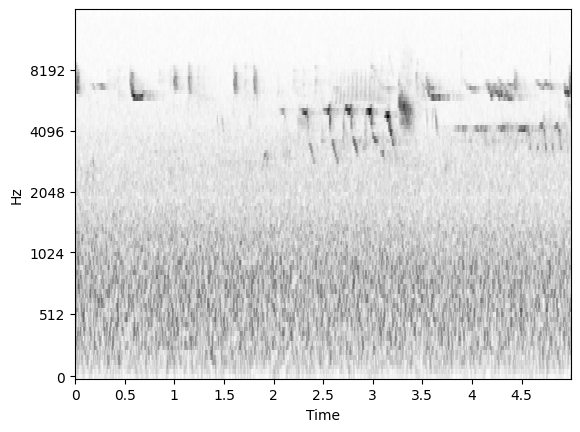

(1, filename       2022/21-RAINBOFSH_20220611_060000.wav
timestamp_s                                    475.0
label                                    herwar_song
logit                                          -2.01
Name: 1, dtype: object)
species: herwar_song, logit: -2.01, filename: 2022/21-RAINBOFSH_20220611_060000.wav, offset: 475.0


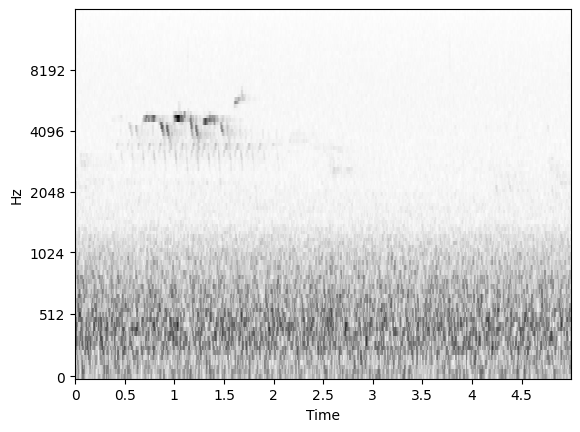

(2, filename       2022/BLACK-10-CAP_20220603_200000.wav
timestamp_s                                    215.0
label                                    herwar_song
logit                                          -2.01
Name: 2, dtype: object)
species: herwar_song, logit: -2.01, filename: 2022/BLACK-10-CAP_20220603_200000.wav, offset: 215.0


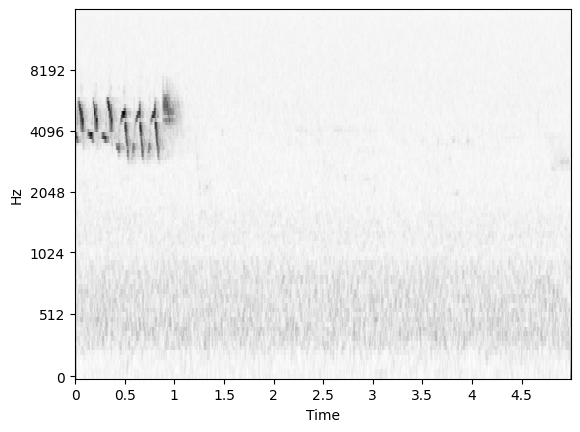

(3, filename       2022/BLUE-6-CAP_20220608_180000.wav
timestamp_s                                  170.0
label                                  herwar_song
logit                                        -2.01
Name: 3, dtype: object)
species: herwar_song, logit: -2.01, filename: 2022/BLUE-6-CAP_20220608_180000.wav, offset: 170.0


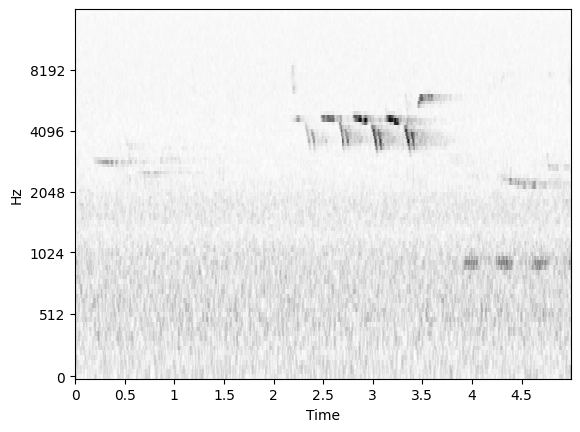

(4, filename       2022/9-BROWN-CAPL_20220619_090000.wav
timestamp_s                                     30.0
label                                    herwar_song
logit                                          -2.01
Name: 4, dtype: object)
species: herwar_song, logit: -2.01, filename: 2022/9-BROWN-CAPL_20220619_090000.wav, offset: 30.0


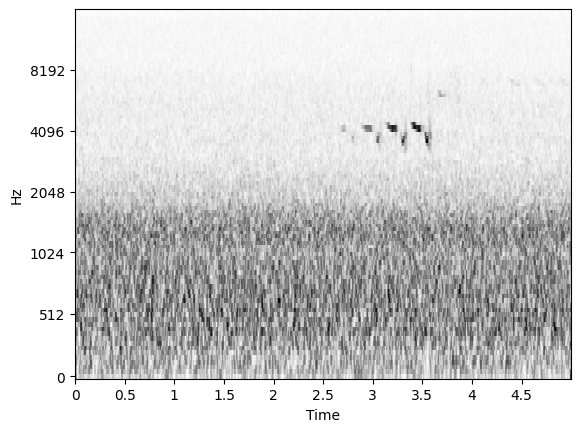

KeyboardInterrupt: 

In [26]:
show_spec_classified_species('herwar_song', herwar, 5, 'ARU_data_all', sample_rate)

# AGGREGATIONS BELOW!!

In [32]:
westan_file_agg = westan.groupby('filename').agg({'logit': 'max'})

In [33]:
westan_file_agg

,logit
filename,
1-CLEAR_mini/Data/1-CLEAR_20230528_073253.wav,-5.17
1-CLEAR_mini/Data/1-CLEAR_20230528_073437.wav,-5.27
1-CLEAR_mini/Data/1-CLEAR_20230528_080000.wav,-5.49
1-CLEAR_mini/Data/1-CLEAR_20230528_083000.wav,-4.79
1-CLEAR_mini/Data/1-CLEAR_20230528_090000.wav,-7.03
...,...
D4-RED-CAPLE/Data/D4-RED-CAPLE_20230620_043000.wav,-9.26
D4-RED-CAPLE/Data/D4-RED-CAPLE_20230620_050000.wav,-7.55
D4-RED-CAPLE/Data/D4-RED-CAPLE_20230620_053000.wav,-4.87


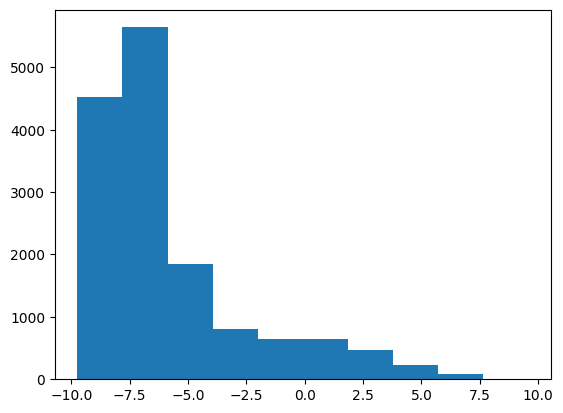

In [35]:
plt.hist(westan_file_agg['logit'])
# plt.yscale('log')
plt.show()

In [ ]:
def show_classified_spec(filename, offset_s, sample_rate):
    audio = audio_utils.load_audio(filename, sample_rate)
    start = int(offset_s * sample_rate)
    end = start + int(5 * sample_rate)
    audio_snippet = audio[start:end]
    display.plot_audio_melspec(audio_snippet, sample_rate)

def show_spec_classified_species(species, classified, n, audio_path, sample_rate):
    filtered = classified.filter(pl.col('label') == species)
    filtered = filtered.sort(by=['logit'], descending=True)
    filtered = filtered.filter(pl.col('logit') < -2)
    filtered = filtered.to_pandas(use_pyarrow_extension_array=True)
    # year = filtered['filename'].str.split('/').str[0].astype(int)
    # filtered = filtered[year <= 2019]
    for i, window in enumerate(filtered.iterrows()):
        if i < n:
            print(window)
            filename = window[1]['filename']
            offset_s = window[1]['timestamp_s']
            logit = window[1]['logit']
            print(f'species: {species}, logit: {logit}, filename: {filename}, offset: {offset_s}')
            show_classified_spec(f'./{audio_path}/{filename}', offset_s, sample_rate)

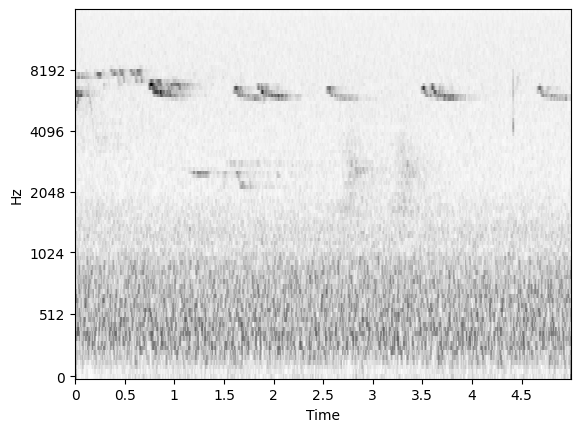

In [5]:
audio = audio_utils.load_audio('./ARU_data_all/2019/GREEN-5-CAPL_20190614_083000.wav', sample_rate)
start = int(135 * sample_rate)
end = start + int(5 * sample_rate)
audio_snippet = audio[start:end]
display.plot_audio_melspec(audio_snippet, sample_rate)